# CIS519, Fall 2021
# File Management with AWS S3 and SageMaker

## EBS vs S3

The data we see in our "working area" is stored on something called an EBS instance. This instance is tied to your specific notebook instance (you can only access it while your notebook is running, and any unsaved changes are lost when your notebook shuts down). The amount of space for the EBS instance is defined when you create the notebook (default 5 GB). You can only update this space when the notebook instace is stopped, and can only increase the amount of space (you cannot decrease, and do get charged per GB, so try to only allocate what you need). This is likely going to be the easiest way to access files for your project.

AWS also allows you to store files in a system called S3.  Unlike the EBS instances, an S3 Bucket is not tied to your specific notebook instances, and can be thought of as more of a general cloud storage. S3 is especially useful for storing backups of files and for storing files you want others to download. You can pull data directly from S3 to SageMaker Notebooks via a module called Boto3, though the process is a bit more complex than simply uploading to the EBS instance. We'll show you a brief overview of that process here.

Just to reiterate, you do not have to use S3 to access your files. If you are ok with the restrictions above, you can just upload directly to the EBS instance. But if you want to store backups of files, or store files you want others to be able to access, it is good to know how to use s3.



## Storing Files in S3

Storing files in s3 is quite easy! You simply have to create an s3 Bucket.To do so, simply navigate to the "S3" service and press "Create Bucket." You should be directed to a page that looks like this:

![picture](https://drive.google.com/uc?export=view&id=13FrJ-6nZcWd9qfDNFcJfWQ-TCcJC_6KV)

Let's go over the settings:

a) The Bucket Name has to be unique within the group of all standard AWS regions, so it will likely have to be pretty convoluted ("i.e. "MyBucket" will likely be rejected). 

Also make sure you set the region to be North Virginia, as that is the only region you have permission to use.


b) Next, you want to set your security settings. Amazon generally recommends blocking public access if you can to avoid putting any sensitive data into public hands. Additionally, you get charged to pull data from S3, so having your S3 bucket open to the public could lead to you being charged more if lots of people download the data. These are likely not going to matter very much for your projects, and you can likely leave this as is (though if you run into access issues, in your cases it will usually not be a problem to loosen these restrictions either).


c) You can also enable Bucket Versioning if you which, will enable you to store multiple variants of objects for version control. If you plan on changing and reuploading data to S3, and don't want to worry about storing backups elsewhere, this might be smart to use!

d) Tags can be used to help track the cost of your bucket- don't worry about that.

e) You also don't have to worry about changing the encryption or any of the advanced settings.

When you are ready, click "Create Bucket" once more!

---

You should be able to see all your buckets in a page like this:

![picture](https://drive.google.com/uc?export=view&id=1BfRinKi37sWbXfHUxc27PJxcZZgHeUjG)

Simply click on a Bucket name to access it. Here you can change many of the settings and permissions we discussed, view bucket analytics, and most importantly, upload files! The files work very much like any file management system. You can upload single files or entire folders, which then have a path directing to them. 

![picture](https://drive.google.com/uc?export=view&id=1Oj6nGSKDxAEGlwyUVxaZiG0R30snAxix)

On any given folder or file, you can click the "Copy S3 URI" button to get what is essentially its path (you will use this when connecting to S3). You can also navigate the path at the top of the screen.

## Connecting to files in S3

To connect to s3, we use a package called boto3. This will essentially be our 'link' to our s3 bucket. To start, let's do some imports and set up our basic client, storing our role and region.

Note: Amazon actually has a wide variety of wrappers and functions meant to use machine learning on S3 files. We are opting for a simpler approach so that you do not have to learn an entire new ecosystem this late in the game. But if you want to use SageMaker in the future, it may be worth following the official AWS tutorials!

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import transform
import boto3
import sagemaker
from sagemaker import get_execution_role
import tempfile
import PIL
import io

In [ ]:
%%time

role = get_execution_role()
print(role)

region = boto3.Session().region_name
sess = sagemaker.Session()



arn:aws:iam::601254666691:role/SageMakerExecutionRole
CPU times: user 118 ms, sys: 16.6 ms, total: 135 ms
Wall time: 290 ms


Let's start simple- loading a single csv into a dataframe. We'll use the weather data you used in your recent HW. 

Here, we just have to know a few things:

1. To get our low-level representation of our s3 services, we use boto3.client('s3')
2. s3 stores its files as objects. From our client, we use the .get_object method, and pass in our bucket name along with our file path.
3. obj['Body'].read() reads the object into bytes, which we can convert to strings using the BytesIO function from the io package.

And there you go! That simple!

Note: The client is a low-level representation of the s3 object. You can also use a resource `boto3.resource()`, which is a higher level abstraction. It is often wise to use a resource, as they tend to allow you to write simpler code, though not every action can be handled using a resource. We will use a resource in a later example.

In [ ]:
bucket = 'test1342335646'
file_path = 'sagemaker/observations.csv'

s3_client = boto3.client('s3')

obj = s3_client.get_object(Bucket=bucket, Key=file_path)

df = pd.read_csv(io.BytesIO(obj['Body'].read()))
df.head()

,Unnamed: 0,wsid,mdct,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,0,178,2007-11-06 00:00:00,NaN,982.5,982.5,981.3,NaN,29.3,12.1,29.7,16.8,25.5,10.8,35.0,58.0,32.0,3.2,101.0,6.5
1,1,178,2007-11-06 01:00:00,NaN,983.2,983.2,982.5,NaN,29.0,13.5,29.9,13.6,29.0,12.2,39.0,39.0,35.0,3.6,94.0,6.4
2,2,178,2007-11-06 02:00:00,NaN,983.5,983.5,983.2,NaN,27.4,14.0,29.0,14.0,27.4,13.6,44.0,44.0,39.0,2.5,93.0,6.9
3,3,178,2007-11-06 03:00:00,NaN,983.7,983.7,983.4,NaN,25.8,16.9,27.4,16.9,25.8,14.1,58.0,58.0,44.0,1.7,96.0,5.8
4,4,178,2007-11-06 04:00:00,NaN,983.7,983.8,983.6,NaN,25.4,16.4,26.3,17.0,25.3,16.4,57.0,58.0,56.0,3.1,110.0,7.5


Things are a bit more complex when we want to use our files to create custom Pytorch Datasets to use with Pytorch DataLoaders. But don't worry, it is not that different!

We are going to work in the context of an image classification problem, where we are trying to classify pictures of ants vs bees. In order to work with a Pytorch dataloader for our CNN, we first have to create a Pytorch Dataset, which as we remember, should be comprised of tensors.

We will inherit the Dataset class from Pytorch to do this. Note that the __getitem__ method will be called when we call our object without any additional attributes. 

To start, we want to get the name of our s3 bucket along with the path to the folder/file of interest. The `boto3.resource('s3')` command will provide our connection to s3. `boto3.resource('s3').Bucket(bucket_name)` will connect to our s3 bucket of interest.

Then that just leaves getting the actual data. Data in s3 is stored as objects. To get all the files in your bucket, you can use the `.all()` method, an to only get some, you can use the `.filter` method and pass in the path to Prefix. The `.key` attribute will get you the file name. For more information on these objects, refer here: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/collections.html

Our data is set up so that we have a train and a validation folder already set up. In each of those folders, we have a 'bees' and an 'ants' folder which store the pictures of each respective insect.

So, we do a simple 3 step process: 
1. Get a list of our file names from our desired folder
2. use those names in __getitem__ to first infer the label based off whether the word '/bees/' or '/ants/' appears in the file path
3. in __getitem__, use the file name to access the respective object (using the bucket we already defined in __init__), then download the file object to a temporary file, open the image, and store it as our returned image (which then gets transformed into a Tensor).

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, bucket='test1342335646', file_path = 'sagemaker/transfer-learning/hymenoptera_data/train/', transform=None):
        #e.g. 'sagemaker/transfer-learning/hymenoptera_data/train/'
        self.file_path = file_path
        self.s3 = boto3.resource('s3')
        self.bucket = self.s3.Bucket(bucket)
        
        #Get the file names for each object in the specified folder of our s3 bucket
        self.files = [obj.key for obj in self.bucket.objects.filter(Prefix=self.file_path)]
        self.transform = transform
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((128, 128)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    def __len__(self):
        return len(self.files)
    
    # the end objects of our dataset, which we want to be tensors
    def __getitem__(self, idx):
        img_name = self.files[idx]
        
        # get label based on which folder our image is in. To be more robust, you would probably want
        # to use regex here, but this is just for demo purposes so we'll go simple
        if '/bees/' in img_name:
            label = 1
        elif '/ants/' in img_name:
            label = 0

        # we can download the file from S3 to a temporary file locally, then store that opened file as our image variable.
        # we need to create the local file name
        obj = self.bucket.Object(img_name)
        tmp = tempfile.NamedTemporaryFile()
        tmp_name = '{}.jpg'.format(tmp.name)

        # now we can actually download from S3 to a local place
        with open(tmp_name, 'wb') as f:
            obj.download_fileobj(f)
            f.flush()
            f.close()
            image = PIL.Image.open(tmp_name)
        
        # Remember we want all of our output to be in tensor form. This is included in the transform method we made, but we need to do it again for the labels
        # Also remember that your labels cannot be strings if you want to turn them into tensors
        if self.transform:
            image = self.transform(image)
        

        return image, torch.tensor(label)
    
    # Function for getting the images to view
    def get_image(self, idx):
        img_name = self.files[idx]

        # we need to download the file from S3 to a temporary file locally
        # we need to create the local file name
        obj = self.bucket.Object(img_name)
        tmp = tempfile.NamedTemporaryFile()
        tmp_name = '{}.jpg'.format(tmp.name)

        # now we can actually download from S3 to a local place
        with open(tmp_name, 'wb') as f:
            obj.download_fileobj(f)
            f.flush()
            f.close()
            image = PIL.Image.open(tmp_name)
            
        return image

In [ ]:
# create train and validation datasets
dataset = ImageDataset()
val_dataset = dataset = ImageDataset(file_path = 'sagemaker/transfer-learning/hymenoptera_data/val/')

In [ ]:
dataset.files

['sagemaker/transfer-learning/hymenoptera_data/val/ants/10308379_1b6c72e180.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1053149811_f62a3410d3.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1073564163_225a64f170.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1119630822_cd325ea21a.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1124525276_816a07c17f.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/11381045_b352a47d8c.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/119785936_dd428e40c3.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1247887232_edcb61246c.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1262751255_c56c042b7b.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1337725712_2eb53cd742.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1358854066_5ad8015f7f.jpg',
 'sagemaker/transfer-learning/hymenoptera_data/val/ants/1440002809_b268d9a66a.jpg

In [ ]:
len(dataset)

153

In [ ]:
dataset[0]

(tensor([[[ 0.5529,  0.6078,  0.6314,  ...,  0.4039,  0.4039,  0.3412],
          [ 0.5294,  0.4745,  0.4510,  ...,  0.4118,  0.3647,  0.3412],
          [ 0.5373,  0.4667,  0.4980,  ...,  0.3412,  0.2863,  0.3569],
          ...,
          [ 0.2706,  0.5765,  0.6392,  ...,  0.2078,  0.1608, -0.0667],
          [ 0.2314,  0.6314,  0.6157,  ...,  0.2471,  0.2078,  0.3569],
          [ 0.3569,  0.5373,  0.5137,  ..., -0.0196,  0.0745,  0.1608]],
 
         [[ 0.8745,  0.8510,  0.8588,  ...,  0.7020,  0.7020,  0.5373],
          [ 0.8275,  0.7804,  0.7804,  ...,  0.6157,  0.6549,  0.5922],
          [ 0.8353,  0.7569,  0.7961,  ...,  0.4275,  0.5216,  0.5922],
          ...,
          [ 0.4353,  0.7490,  0.8196,  ...,  0.2784,  0.2863,  0.1686],
          [ 0.4039,  0.7882,  0.8196,  ...,  0.2784,  0.3255,  0.5059],
          [ 0.5843,  0.7490,  0.7333,  ...,  0.0353,  0.1922,  0.2627]],
 
         [[ 0.9137,  0.8824,  0.9059,  ...,  0.7569,  0.7490,  0.5843],
          [ 0.8745,  0.8588,

Now let's just visualize a few of our images to make sure things look right

(500, 375)
<class 'PIL.JpegImagePlugin.JpegImageFile'>
(500, 375)
<class 'PIL.JpegImagePlugin.JpegImageFile'>
(500, 375)
<class 'PIL.JpegImagePlugin.JpegImageFile'>
(500, 400)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


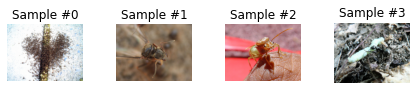

In [ ]:
fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset.get_image(i)

    print(sample.size)
    print(type(sample))
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample)

    if i == 3:
        plt.show()
        break

## Let's get learning! Transfer Learning with Our Loaded Data

Now that we have our data loaded from S3, we can use it just as we would any other data. Here, we are adapting the transfer learning example from Pytorch's tutorial, found here: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

The only aspects of their code we changed are adjusting the data loaders to use our created datasets and removing the .todevice() lines, since we don't need those on this notebook instance. Since this tutorial is on connecting to S3 and not transfer learning, this code is included mainly as proof that our data loading worked. We recommend reading the linked tutorial to get a better conceptual understanding of the code below.

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
image_datasets = {'train': dataset, 'val': val_dataset}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6822 Acc: 0.6601
val Loss: 0.1937 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.4200 Acc: 0.8366
val Loss: 0.2235 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.3344 Acc: 0.8954
val Loss: 0.1060 Acc: 0.9608

Epoch 3/24
----------
train Loss: 0.4665 Acc: 0.8170
val Loss: 0.1503 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.5006 Acc: 0.8301
val Loss: 0.0698 Acc: 0.9804

Epoch 5/24
----------
train Loss: 0.3871 Acc: 0.8431
val Loss: 0.0590 Acc: 0.9804

Epoch 6/24
----------
train Loss: 0.3952 Acc: 0.8431
val Loss: 0.0460 Acc: 0.9804

Epoch 7/24
----------
train Loss: 0.2642 Acc: 0.8889
val Loss: 0.0243 Acc: 0.9935

Epoch 8/24
----------
train Loss: 0.2000 Acc: 0.9216
val Loss: 0.0250 Acc: 0.9935

Epoch 9/24
----------
train Loss: 0.2833 Acc: 0.8954
val Loss: 0.0183 Acc: 0.9935

Epoch 10/24
----------
train Loss: 0.2320 Acc: 0.8954
val Loss: 0.0232 Acc: 0.9935

Epoch 11/24
----------
train Loss: 0.1167 Acc: 0.9608
val Loss: 0.0145 Acc: 1.0000

Ep